<a href="https://colab.research.google.com/github/raniaAprilia/Capstone_Project-ML/blob/main/FaceShape_Detection_Modif1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [1]:
import os
from google.colab import files
import pandas as pd
import cv2
from sklearn.utils import shuffle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)

In [ ]:
upload = files.upload()
# from google.colab import drive
# drive.mount('/content/drive')

Saving face-shape-dataset-metadata.json to face-shape-dataset-metadata.json


In [ ]:
if not os.path.exists('/root/.kaggle'):
  os.makedirs('/root/.kaggle')

!mv face-shape-dataset-metadata.json /root/.kaggle/
!chmod 600 /root/face-shape-dataset-metadata.json
# import zipfile

# # Specify the path to the ZIP file
# zip_path = '/content/drive/MyDrive/archive.zip'

# # Extract the ZIP file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall('/content/')


chmod: cannot access '/root/face-shape-dataset-metadata.json': No such file or directory


In [2]:
!kaggle datasets download -d niten19/face-shape-dataset

Dataset URL: https://www.kaggle.com/datasets/niten19/face-shape-dataset
License(s): CC0-1.0
 97% 622M/639M [00:08<00:00, 74.5MB/s]
100% 639M/639M [00:08<00:00, 80.6MB/s]


In [3]:
!unzip face-shape-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: FaceShape Dataset/testing_set/Heart/heart (123).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (13).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (135).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (136).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (137).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (138).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (139).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (140).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (141).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (156).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (161).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (163).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (189).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (192).jpg  
  inflating:

In [4]:
class_names=['Heart', 'Oblong', 'Oval', 'Round', 'Square']
lable = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes= len(class_names)
IMAGE_SIZE=(150, 150)
BATCH_SIZE = 32

In [5]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.2,  # Penambahan shear
    zoom_range=0.2,  # Penambahan zoom
    height_shift_range=0.2,  # Pergeseran vertikal
    rescale=1./255.
)
testing_datagen = ImageDataGenerator(
    rescale=1./255.
)

NameError: name 'train_data_dir' is not defined

In [6]:
def load_data():
  datasets =['/content/FaceShape Dataset/training_set','/content/FaceShape Dataset/testing_set']
  output = []

  for dataset in datasets:
    images = []
    labels = []

    print("Loading {}.".format(dataset))
    for folder in os.listdir(dataset):
      if folder != "desktop.ini" and folder != ".ipynb_checkpoints":
        if ".ipynb_checkpoints" in dataset:
          os.rmdir(".ipynb_checkpoints")
        label = lable[folder]
        for file in tqdm(os.listdir(os.path.join(dataset, folder))):
          if file != "desktop.ini":
            img = os.path.join(os.path.join(dataset, folder), file)
            try:
              image = cv2.imread(img)
              image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              image = cv2.resize(image, IMAGE_SIZE)
              if dataset.endswith('training_set'):

                  image = train_datagen.random_transform(image)
              elif dataset.endswith('testing_set'):
                image = testing_datagen.random_transform(image)
              images.append(image)
              labels.append(label)
            except Exception as e:
              print(f"Broken: {e,img}")
            continue
    images = np.array(images, dtype ='float32')
    labels = np.array(labels, dtype='int32')
    output.append((images, labels))
  return output

In [7]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/FaceShape Dataset/training_set.


 77%|███████▋  | 617/800 [00:16<00:03, 47.08it/s]

Broken: (error("OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'\n"), '/content/FaceShape Dataset/training_set/Oblong/oblong (724).jpg')


100%|██████████| 800/800 [00:10<00:00, 75.29it/s]


Loading /content/FaceShape Dataset/testing_set.


100%|██████████| 200/200 [00:02<00:00, 83.70it/s]


In [ ]:
# Menampilkan beberapa gambar asli sebelum augmentasi untuk verifikasi
# def plot_images(images_arr, n_images=10):
#     fig, axes = plt.subplots(1, n_images, figsize=(20, 20))
#     axes = axes.flatten()
#     for img, ax in zip(images_arr, axes):
#         ax.imshow(img.astype(np.uint8))
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()
# print("Gambar asli:")
# plot_images(X_train[:10])

In [8]:
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")

Train images shape: (3999, 150, 150, 3)
Train labels shape: (3999,)


In [9]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

train_images = train_images / 255.0
test_images = test_images / 255.0

Number of training examples: 3999
Number of testing examples: 1000
Each image is of size: (150, 150)


In [10]:
# model = tf.keras.Sequential([

#     tf.keras.layers.Conv2D(60, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2,2),

#     tf.keras.layers.Conv2D(50, (3, 3), activation = 'relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.Conv2D(50, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.Conv2D(40, (3, 3), activation = 'relu'),
#     tf.keras.layers.MaxPooling2D(2,2),

#     tf.keras.layers.Conv2D(30, (3, 3), activation = 'relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(65, activation=tf.nn.softmax),
#     tf.keras.layers.Dropout(0.2)

# ])


from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.regularizers import l2
base_model = InceptionV3(weights='imagenet', include_top = False, input_shape=(150,150,3))
# base_model = VGG16(weights='imagenet', include_top = False, input_shape=(150,150,3))
# base_model = ResNet50(weights='imagenet', include_top = False, input_shape=(150,150,3))

87910968/87910968 [==============================] - 1s 0us/step


model 1 (tranfer learning)


In [55]:
for layer in base_model.layers:
  layer.trainable = False

num_classes = len(class_names)
# Menambahkan lapisan baru untuk klasifikasi
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
# x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.Dropout(.2)(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(10, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Membuat model baru dengan lapisan InceptionV3 dan lapisan baru
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# num_classes = len(class_names)
# input_shape = (150, 150, 3)

# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])
# for layer in base_model.layers[:-5]:
#   layer.trainable = False

# num_classes = len(class_names)
# # Menambahkan lapisan baru untuk klasifikasi
# x = base_model.output
# x = tf.keras.layers.Conv2D(128, (3,3), activation ='relu')(x)  # Menambahkan lapisan konvolusi dengan lebih banyak filter
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)  # Menambahkan lapisan tersembunyi
# outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# # Membuat model baru dengan lapisan InceptionV3 dan lapisan baru
# model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

In [56]:
# model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='SGD', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [59]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)

In [60]:
history = model.fit(train_images, train_labels, steps_per_epoch=100,batch_size= 32, epochs=50, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 4s 44ms/step - loss: 1.6491 - accuracy: 0.2678 - val_loss: 1.9379 - val_accuracy: 0.0025
Epoch 2/50
100/100 [==============================] - 4s 41ms/step - loss: 1.5758 - accuracy: 0.2806 - val_loss: 1.8618 - val_accuracy: 0.0100
Epoch 3/50
100/100 [==============================] - 4s 40ms/step - loss: 1.5529 - accuracy: 0.3088 - val_loss: 1.8851 - val_accuracy: 0.0125
Epoch 4/50
100/100 [==============================] - 4s 37ms/step - loss: 1.5363 - accuracy: 0.2966 - val_loss: 1.8951 - val_accuracy: 0.0075
Epoch 5/50
100/100 [==============================] - 4s 38ms/step - loss: 1.5264 - accuracy: 0.3164 - val_loss: 1.8935 - val_accuracy: 0.0200
Epoch 6/50
100/100 [==============================] - 4s 43ms/step - loss: 1.5149 - accuracy: 0.3189 - val_loss: 1.8314 - val_accuracy: 0.0100
Epoch 7/50
100/100 [==============================] - 4s 39ms/step - loss: 1.5051 - accuracy: 0.3283 - val_loss: 1.9268 - val_accuracy: 0.0100

model 2

In [ ]:
# def get_compiled_model(num_classes):
#     inputs = keras.Input(shape=(28, 28, 1))
#     x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
#     # x = tf.keras.layers.Dense(1024, activation='relu')(x)
#     x = tf.keras.layers.Dense(1024, activation='relu')(x)
#     # x = tf.keras.layers.Dense(512, activation='relu')(x)
#     # x = keras.layers.Dense(256, activation="relu")(x)
#     x = keras.layers.Dense(10, activation="relu")(x)
#     outputs = keras.layers.Dense(num_classes)(x)
#     model = keras.Model(inputs=inputs, outputs=outputs)
#     model.compile(
#         optimizer=keras.optimizers.Adam(),
#         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=[keras.metrics.SparseCategoricalAccuracy()],
#     )
#     return model

# # def get_compiled_model():
# #     # Make a simple 2-layer densely-connected neural network.


# #     model2 = keras.Model(inputs, outputs)
# #     model2.compile(
# #         optimizer=keras.optimizers.Adam(),
# #         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
# #         metrics=[keras.metrics.SparseCategoricalAccuracy()],
# #     )
# #     return model2

In [ ]:
# def get_dataset():
#     batch_size = 32
#     num_val_samples = 10000

#     # Example using MNIST, replace with your own data loading
#     (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
#     x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255
#     x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255
#     y_train = y_train.astype("float32")
#     y_test = y_test.astype("float32")

#     # Reserve num_val_samples samples for validation
#     x_val = x_train[-num_val_samples:]
#     y_val = y_train[-num_val_samples:]
#     x_train = x_train[:-num_val_samples]
#     y_train = y_train[:-num_val_samples]

#     train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
#     val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
#     test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

#     return train_dataset, val_dataset, test_dataset

In [ ]:
# checkpoint_dir = "./ckpt"
# if not os.path.exists(checkpoint_dir):
#     os.makedirs(checkpoint_dir)

In [ ]:
# def make_or_restore_model(num_classes):
#     # Either restore the latest model, or create a fresh one
#     # if there is no checkpoint available.
#     checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
#     if checkpoints:
#         latest_checkpoint = max(checkpoints, key=os.path.getctime)
#         print("Restoring from", latest_checkpoint)
#         return keras.models.load_model(latest_checkpoint)
#     print("Creating a new model")
#     return get_compiled_model(num_classes)

In [ ]:
# def run_training(epochs=1):
#     # Create a MirroredStrategy.
#     strategy = tf.distribute.MirroredStrategy()

#     # Open a strategy scope and create/restore the model
#     with strategy.scope():
#         num_classes = 5  # Set this to the correct number of classes
#         model = make_or_restore_model(num_classes)

#         train_dataset, val_dataset, test_dataset = get_dataset()

#         callbacks = [
#             # This callback saves a SavedModel every epoch
#             # We include the current epoch in the folder name.
#             keras.callbacks.ModelCheckpoint(
#                 filepath=checkpoint_dir + "/ckpt-{epoch}.keras",
#                 save_freq="epoch",
#             )
#         ]
#         history = model.fit(
#             train_dataset,
#             epochs=epochs,
#             batch_size=32,
#             callbacks=callbacks,
#             validation_data=val_dataset,
#             verbose=2,
#         )
#         return history

# # Running the training and plotting the results
# history = run_training(epochs=25)
# plot_accuracy_loss(history)


Restoring from ./ckpt/ckpt-8.keras
Epoch 1/25
1563/1563 - 10s - loss: 2.0690 - sparse_categorical_accuracy: 0.2285 - val_loss: 2.0432 - val_sparse_categorical_accuracy: 0.2396 - 10s/epoch - 6ms/step
Epoch 2/25
1563/1563 - 7s - loss: 2.0688 - sparse_categorical_accuracy: 0.2279 - val_loss: 2.0432 - val_sparse_categorical_accuracy: 0.2382 - 7s/epoch - 4ms/step
Epoch 3/25
1563/1563 - 8s - loss: 2.0687 - sparse_categorical_accuracy: 0.2280 - val_loss: 2.0430 - val_sparse_categorical_accuracy: 0.2386 - 8s/epoch - 5ms/step
Epoch 4/25
1563/1563 - 7s - loss: 2.0687 - sparse_categorical_accuracy: 0.2280 - val_loss: 2.0431 - val_sparse_categorical_accuracy: 0.2380 - 7s/epoch - 4ms/step
Epoch 5/25
1563/1563 - 7s - loss: 2.0687 - sparse_categorical_accuracy: 0.2282 - val_loss: 2.0432 - val_sparse_categorical_accuracy: 0.2392 - 7s/epoch - 4ms/step
Epoch 6/25
1563/1563 - 8s - loss: 2.0685 - sparse_categorical_accuracy: 0.2278 - val_loss: 2.0436 - val_sparse_categorical_accuracy: 0.2390 - 8s/epoch - 

KeyboardInterrupt: 

In [61]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0]

In [62]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

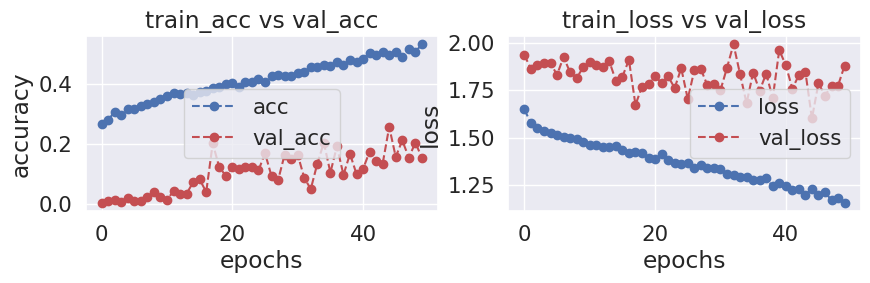

In [63]:
plot_accuracy_loss(history)

In [64]:
test_loss = model.evaluate(test_images, test_labels)

32/32 [==============================] - 1s 35ms/step - loss: 1.4378 - accuracy: 0.4050


In [65]:
def display_random_image(class_names, images, labels):
    """
    #Exibição de uma imagem aleatória
    """

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

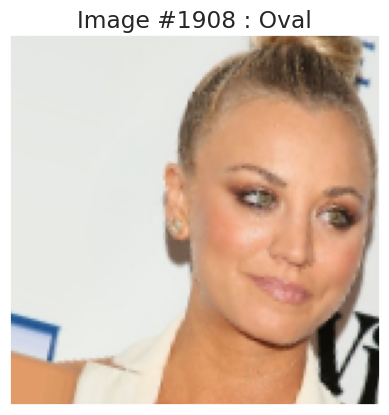

In [66]:
display_random_image(class_names, train_images, train_labels)

32/32 [==============================] - 4s 34ms/step


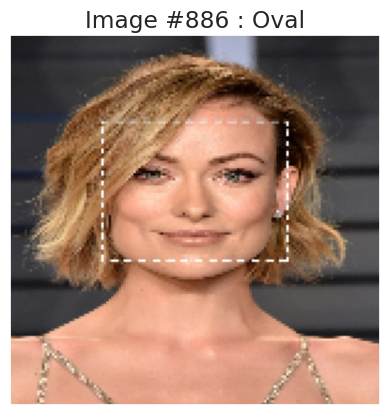

In [67]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

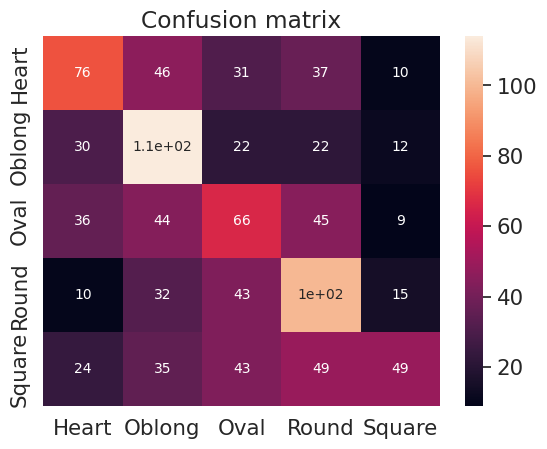

In [68]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels=class_names,
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [69]:
# Matriz de confusão
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, pred_labels)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_labels)
# Recall
from sklearn.metrics import recall_score
recall_score(test_labels, pred_labels, average=None)
# Precision
from sklearn.metrics import precision_score
precision_score(test_labels, pred_labels, average=None)

#f1-score
from sklearn.metrics import f1_score
f1_score(test_labels, pred_labels, average=None)

#Classification Report
from sklearn.metrics import classification_report
print("Classification Report")
print(classification_report(test_labels, pred_labels, target_names=class_names))

Classification Report
              precision    recall  f1-score   support

       Heart       0.43      0.38      0.40       200
      Oblong       0.42      0.57      0.48       200
        Oval       0.32      0.33      0.33       200
       Round       0.40      0.50      0.44       200
      Square       0.52      0.24      0.33       200

    accuracy                           0.41      1000
   macro avg       0.42      0.40      0.40      1000
weighted avg       0.42      0.41      0.40      1000



Saving ca304569-fff7-4ab7-b28a-3290426b6093.jfif to ca304569-fff7-4ab7-b28a-3290426b6093 (1).jfif
1/1 [==============================] - 0s 25ms/step


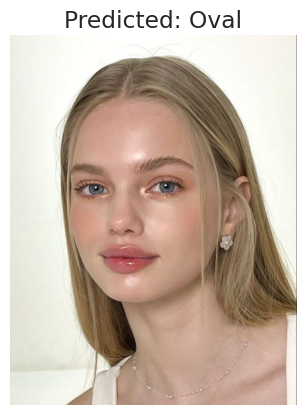

Predicted: Oval
Probabilitas: 0.2664044499397278


In [72]:
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(filename):
    img = image.load_img(filename, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return x

# Unggah file gambar
uploaded = files.upload()

# Memuat dan memproses gambar
for filename in uploaded.keys():
    img_tensor = load_and_preprocess_image(filename)

    # Lakukan prediksi menggunakan model
    predictions = model.predict(img_tensor)

    # Dapatkan kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(predictions)
    predicted_label = class_names[predicted_class]

    # Tampilkan gambar dan hasil prediksi
    plt.imshow(image.load_img(filename))
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

    print(f"Predicted: {predicted_label}")
    print(f"Probabilitas: {predictions[0][predicted_class]}")